Importing modules

In [19]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf

SEED = 1337

Loading in data

In [20]:
test_data = pd.read_csv('data/test_data.csv', dtype={'id': np.int16, 'target': np.int8})
train_data = pd.read_csv('data/train_data.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(train_data.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train_data.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test_data.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test_data.memory_usage().sum() / 1024**2))

print(test_data.head())
print(train_data.head())

Training Set Shape = (35918, 2)
Training Set Memory Usage = 0.55 MB
Test Set Shape = (8980, 2)
Test Set Memory Usage = 0.14 MB
                                             content  label
0  Philippines doctor linked to New York attack p...      1
1  More Republicans expect Clinton, rather than T...      1
2  DEMOCRAT UNDERBELLY EXPOSED: Out-Of-Control Vi...      0
3  Those who boycott Syrian congress may be sidel...      1
4  Burundi opposition platform boycotts new round...      1
                                             content  label
0  Search ends for bodies in Mexico City after ea...      1
1  Former Catalan cabinet members appear before S...      1
2  ATTORNEY FOR STEINLE KILLER Calls Verdict ‘Vin...      0
3  Trump gains on Clinton, poll shows 'rigged' me...      1
4  Republican Trump says 70 percent of federal re...      1


Graphing meta features

In [21]:
# word_count
train_data['word_count'] = train_data['content'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['content'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data['unique_word_count'] = train_data['content'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'] = test_data['content'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_data['stop_word_count'] = train_data['content'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_data['stop_word_count'] = test_data['content'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_data['url_count'] = train_data['content'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_data['url_count'] = test_data['content'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_data['mean_word_length'] = train_data['content'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data['mean_word_length'] = test_data['content'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_data['char_count'] = train_data['content'].apply(lambda x: len(str(x)))
test_data['char_count'] = test_data['content'].apply(lambda x: len(str(x)))

# punctuation_count
train_data['punctuation_count'] = train_data['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_data['punctuation_count'] = test_data['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

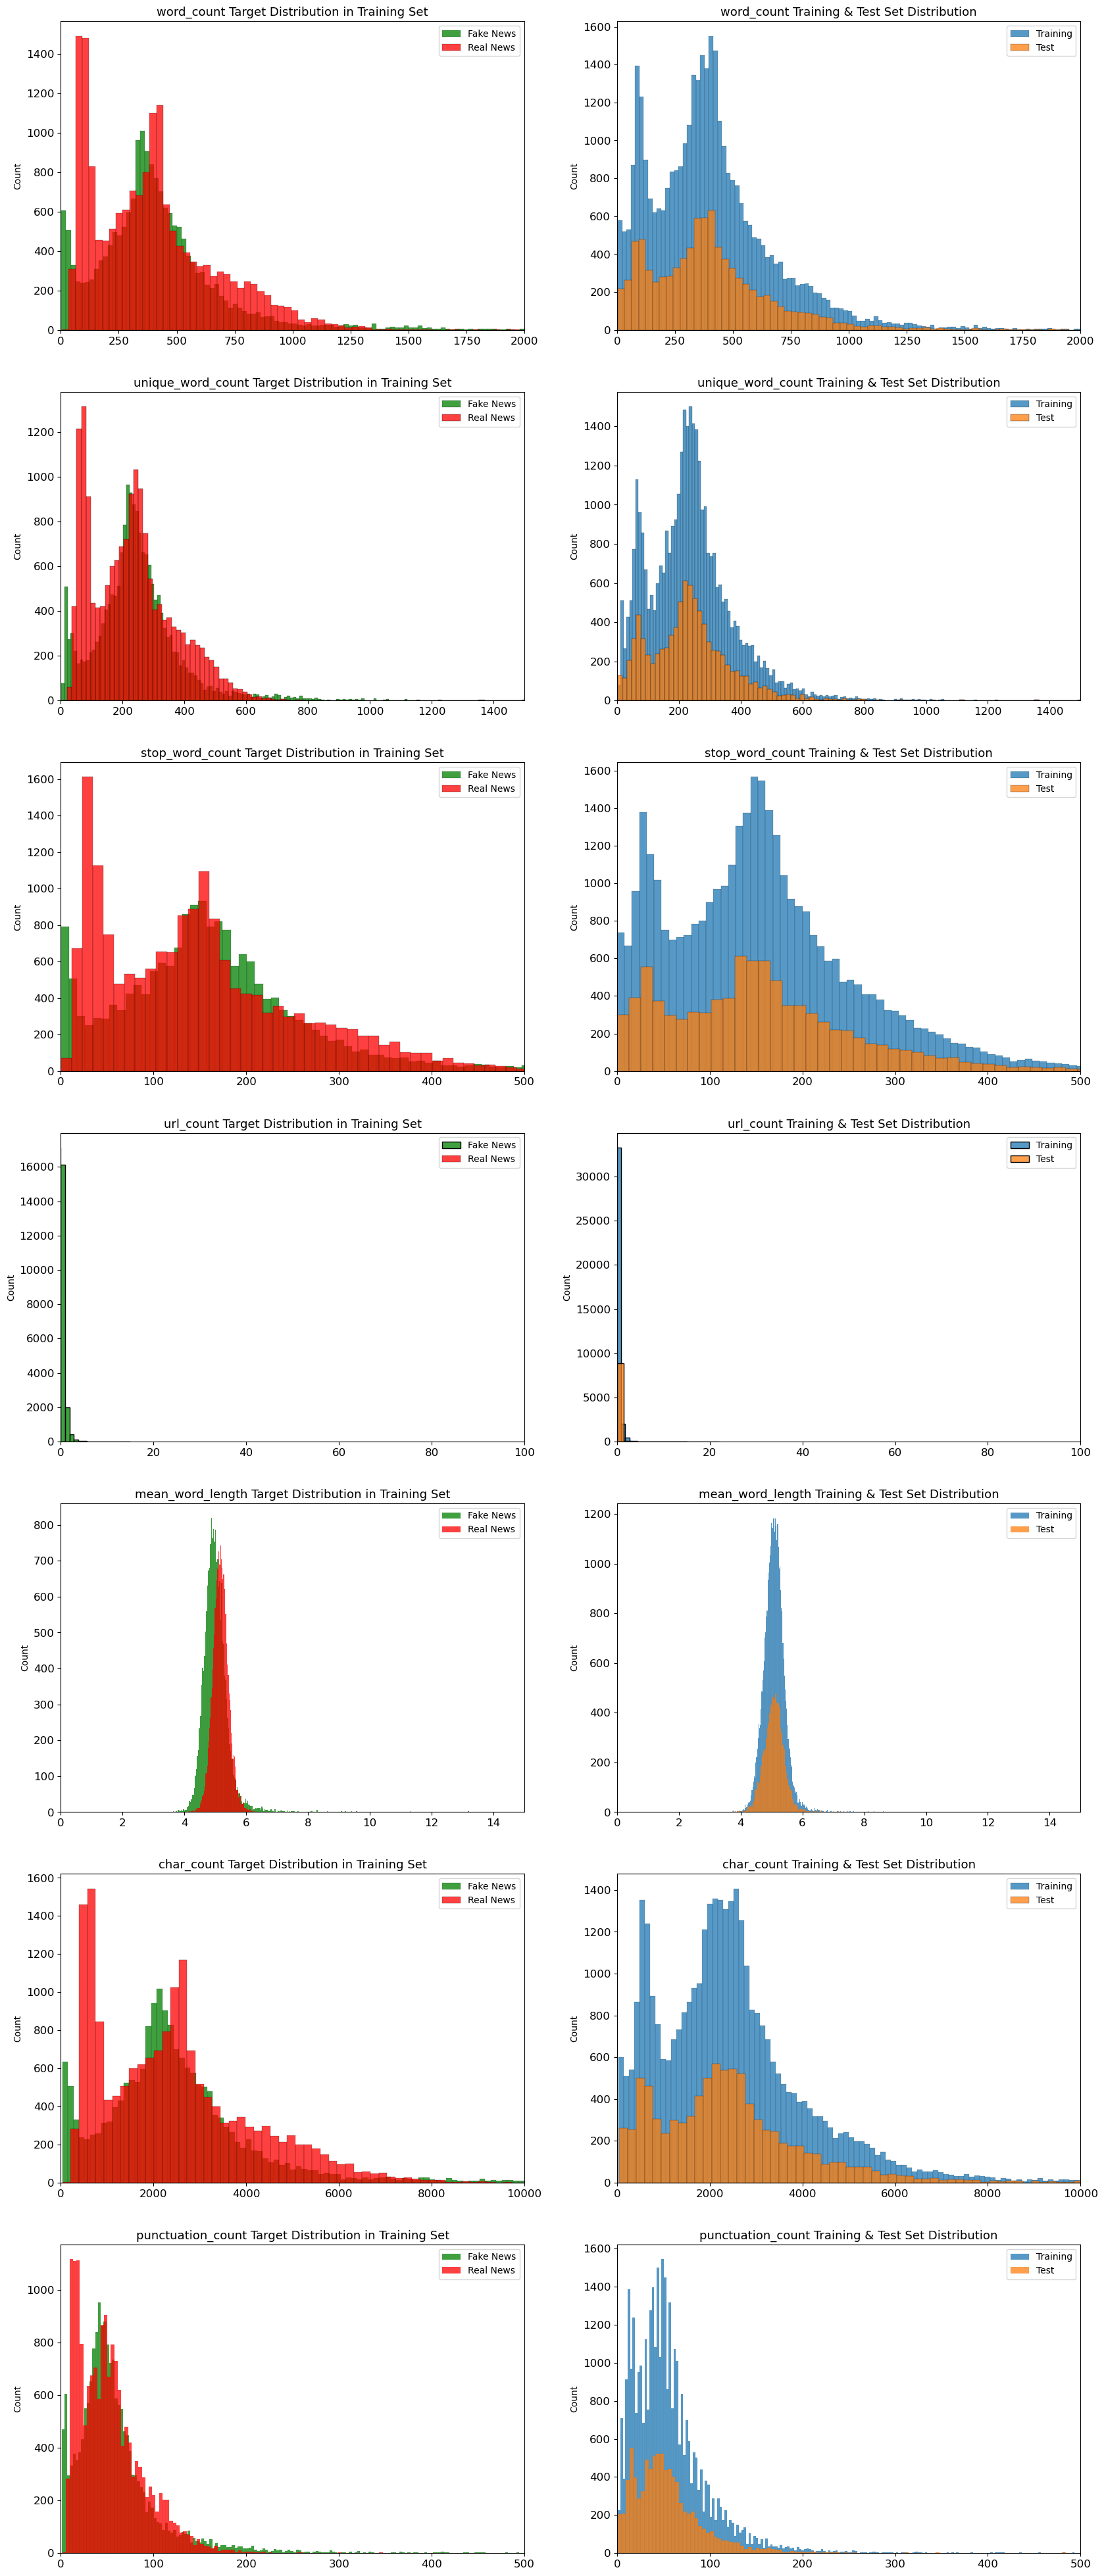

In [27]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count']
FAKE_OR_REAL_NEWS = train_data['label'] == 1

# Define max x-axis values for each feature to spread out the data
max_values = {
    'word_count': 2000,
    'unique_word_count': 1500,
    'stop_word_count': 500,
    'url_count': 100,
    'mean_word_length': 15,
    'char_count': 10000,
    'punctuation_count': 500
}

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(train_data.loc[~FAKE_OR_REAL_NEWS][feature], label='Fake News', ax=axes[i][0], color='green')
    sns.histplot(train_data.loc[FAKE_OR_REAL_NEWS][feature], label='Real News', ax=axes[i][0], color='red')

    sns.histplot(train_data[feature], label='Training', ax=axes[i][1])
    sns.histplot(test_data[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].set_xlim(0, right=max_values[feature])
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

Target

In [ ]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
real_news_unigrams = defaultdict(int)
fake_news_unigrams = defaultdict(int)

for tweet in df_train[FAKE_OR_REAL_NEWS]['text']:
    for word in generate_ngrams(tweet):
        real_news_unigrams[word] += 1

for tweet in df_train[~FAKE_OR_REAL_NEWS]['text']:
    for word in generate_ngrams(tweet):
        fake_news_unigrams[word] += 1

df_real_news_unigrams = pd.DataFrame(sorted(real_news_unigrams.items(), key=lambda x: x[1])[::-1])
df_fake_news_unigrams = pd.DataFrame(sorted(fake_news_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
real_news_bigrams = defaultdict(int)
fake_news_bigrams = defaultdict(int)

for tweet in df_train[FAKE_OR_REAL_NEWS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        real_news_bigrams[word] += 1

for tweet in df_train[~FAKE_OR_REAL_NEWS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        fake_news_bigrams[word] += 1

df_real_news_bigrams = pd.DataFrame(sorted(real_news_bigrams.items(), key=lambda x: x[1])[::-1])
df_fake_news_bigrams = pd.DataFrame(sorted(fake_news_bigrams.items(), key=lambda x: x[1])[::-1])

for tweet in df_train[~FAKE_OR_REAL_NEWS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        fake_news_bigrams[word] += 1

df_real_news_bigrams = pd.DataFrame(sorted(real_news_bigrams.items(), key=lambda x: x[1])[::-1])
df_fake_news_bigrams = pd.DataFrame(sorted(fake_news_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
real_news_trigrams = defaultdict(int)
fake_news_trigrams = defaultdict(int)

for tweet in df_train[FAKE_OR_REAL_NEWS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        real_news_trigrams[word] += 1
        
for tweet in df_train[~FAKE_OR_REAL_NEWS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        fake_news_trigrams[word] += 1

df_real_news_trigrams = pd.DataFrame(sorted(real_news_trigrams.items(), key=lambda x: x[1])[::-1])
df_fake_news_trigrams = pd.DataFrame(sorted(fake_news_trigrams.items(), key=lambda x: x[1])[::-1])

Unigrams

In [ ]:
linkcode
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_real_news_unigrams[0].values[:N], x=df_real_news_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_fake_news_unigrams[0].values[:N], x=df_fake_news_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Real News', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Fake News', fontsize=15)

plt.show()

Bigrams

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_real_news_bigrams[0].values[:N], x=df_real_news_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_fake_news_bigrams[0].values[:N], x=df_fake_news_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Real News', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Fake News', fontsize=15)

plt.show()

Trigrams

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_real_news_trigrams[0].values[:N], x=df_real_news_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_fake_news_trigrams[0].values[:N], x=df_real_news_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Real News', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Fake News', fontsize=15)

plt.show()